In [11]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

#check whether gpu is available
use_gpu=torch.cuda.is_available()

# read file
f = open('input.txt')
result = list()
result.append(f.read())
#for line in f.readlines():    
    #print(line)
    #line = line.strip()                
 #   result.append(line)              
#print(len(result))
#indices_start=[i for i in range(len(result)) if result[i].strip()=='<start>']
#num_tune=len(indices_start)
#tune=list()

#for i in range(len(result)-1):
#    tune.append(''.join(result[indices_start[i]:indices_start[i+1]]))
#tune.append(''.join(result[indices_start[-1]:-1]))

training_data = []
training_targets = []
test_data = []
test_targets = []
sentencelen = 25
for i in range(len(result)):
    #leave one more for validation set
    num_character=len(result[i])
    #k = num_character%sentencelen
    k = num_character//sentencelen
    for j in range(k):
        training_data.append(result[i][j*sentencelen:(j+1)*sentencelen])
        piece = result[i][j*sentencelen+1:(j+1)*sentencelen+1]
        if(len(piece)<sentencelen):
            piece = piece+" "*(sentencelen-len(piece))
        training_targets.append(piece)
    end = ""
    end1 = ""
    if(k*sentencelen<num_character):
        end = result[i][k*sentencelen:len(result[i])]
        if(k*sentencelen+1<num_character):
            end1 = result[i][k*sentencelen+1:len(result[i])]
            end1 = end1+ ' ' * (sentencelen - len(end1))
        else:
            end1 = ' '* sentencelen
        end = end + ' '* (sentencelen - len(end))
        end1 = end1+ ' ' * (sentencelen - len(end1))
        training_data.append(end)
        training_targets.append(end1)
        #print('0'* sentencelen)
print(training_data)
k = int(len(training_data)*0.8)
test_data=training_data[k:]
test_targets=training_targets[k:]
training_data=training_data[:k]
training_targets=training_targets[:k]
#word to index
word_to_ix = {}
ix_to_word = {}
for sent in training_data:
    for characters in sent:
        if characters not in word_to_ix:
            word_to_ix[characters] = len(word_to_ix) 
            ix_to_word[len(word_to_ix)-1] = characters

['<start>\r\nX:1\r\nT: La Montf', 'arine\r\nZ:Transcrit et/ou ', 'corrig? par Michel BELLON', ' - 2005-07-24\r\nZ:Pour tou', 'te observation mailto:gal', 'ouvielle@free.fr\r\nM: 4/4\r', '\nL: 1/8\r\nQ:1/4=186\r\nFGF B', '=AG G=AG F2F FGF {F}F2E E', 'FE|\r\n{E}E2D FGF B=AG G=AG', ' {F}F2F FED C2G D2E|F3 {F', '}F/2 ED E3/2D/2|\r\nEC FE E', '2 DC|DC C2 GD2E|F3F/2F/2 ', 'DE FD|EC B,C D2 B,G|\r\ncB ', '=A2 FG2E|F3F GF B=A|GG =A', 'G F2 FF|GF F/2F3/2 EE FE|', '\r\nE/2E3/2 DF GF B=A|GG =A', 'G F/2F3/2 FF|ED C2 GD2E|F', '3F/2F/2 ED E3/2D/2|\r\nEC F', 'E E2 DC|DC C2 GD2E|F3F/2F', '/2 DE FD|EC B,C D2 B,G|\r\n', 'cB =A2 FF G=A|B3\r\nG2_A G/', '2G3/2-|GF/2F/2 ED F2 EB,|', 'CD EF GB AG|\r\nA3A GA F2|F', '/2F/2F EF D3/2B,/2 B,B,|C', 'D EF GA GF|G3B/2B/2 AB G2', '|\r\nGG/2G/2 FG E2 EB/2B/2|', 'AG BA GG AB|c3c/2c3/2d f2', '|ed eG c2 BB|\r\nAB dc BG A', 'D|E3F GF BA|GG AG F2 FF|G', 'F F/2F3/2 EE FE|\r\nE/2E3/2', ' DF GF BA|GG AG F/2F3/2 F', 'F|ED C2 GD2E|F2- F/2\r\n<en', 'd>\r\n<start>\r\nX: 2\r\nT:Ste

In [12]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for i in range(len(seq)):
        idxs0 = [to_ix[w] for w in seq[i]]
        idxs.append(idxs0)
    idxs = torch.LongTensor(idxs)
    #tensor = tensor.view(batch_size,len(tensor)/batch_size)
    #print(len(idxs))
    return autograd.Variable(idxs)
def one_hot(ids, depth):
    """
    ids: Variable
    out_tensor:FloatTensor shape:[sentencelen, depth]
    """
    out_tensor=torch.Tensor(len(ids),sentencelen,depth)
    #if not isinstance(ids, (list, np.ndarray)):
     #   raise ValueError("ids must be 1-D list or array")
    #ids = torch.LongTensor(ids.data.cpu().numpy()).view(-1,1)
    #print(ids)
    out_tensor.zero_()
    for i in range(len(out_tensor)):
        ids0 = torch.LongTensor(ids[i].data.cpu().numpy()).view(-1,1)
        out_tensor[i].scatter_(dim=1, index=ids0,value=1.)
    #out_tensor = torch.transpose(out_tensor,0,1)
    if torch.cuda.is_available():
        out_tensor=out_tensor.cuda()
    return autograd.Variable(out_tensor)
    

In [13]:
EMBEDDING_DIM = len(word_to_ix)
HIDDEN_DIM = 100
batch_size = 500
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, batch_first = True):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim).cuda()))

    def forward(self, sentence , hidden):
        #print(sentence)
        #embeds = self.word_embeddings(sentence)
        embeds=one_hot(sentence,EMBEDDING_DIM)
        #pack_padded_sequence(embeddings, sentencelen, batch_first=True)
        lstm_out, hidden = self.lstm(
            embeds.view(batch_size,sentencelen, -1), hidden)#
       # print(self.hidden)
       # print(lstm_out.size())
        #lstm_out, _ = pad_packed_sequence(output, batch_first=True)
        tag_scores = self.hidden2tag(lstm_out.contiguous().view(sentencelen,batch_size, -1))
        #tag_scores = F.log_softmax(tag_space)
        return tag_scores,hidden
    


model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(word_to_ix))
loss_function = nn.CrossEntropyLoss()
if use_gpu:
    model.cuda()
    loss_function.cuda()
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9)
#inputs = prepare_sequence(training_data, word_to_ix)
error_train = []
error_valid = []
loss_f = 0
k = 0
epoch = 0


3.54521753571
3.09782597423
2.87995794325
2.62091577053
2.51052422957
2.38058060408
2.27765489347
2.24663287401
2.12589625518
2.21078690886
2.01430606842
2.06422559917
1.92670215982
2.02728770673
1.86243146839
2.00361160934
1.81289438407
1.98985353112
1.77189075947
1.95143346488
1.73786511927
1.92675516009
1.7091910803
1.93713639677
1.684591138
1.89957413077
1.66003626766
1.89978973567
1.63975122119
1.8830640167
1.62087012782
1.87775366008
1.60421812896
1.8753746748
1.5889734969
1.86906850338
1.57305013772
1.86217208207
1.55995563305
1.85513006151
1.54771467772
1.8480181396
1.53566214171
1.84483130276
1.52579458916
1.83965191245
1.51690986301
1.83928118646
1.5071742932
1.8443466723
1.4973795414
1.83721262217
1.49209684314
1.86262363195
1.48317111622
1.8445211798
1.47676240675
1.86025370657
1.47088019414
1.85300457478
1.46363046675
1.8639152199
1.45789321625
1.85289207101
1.45420322996
1.86654525995
1.44848636786
1.8597034812
1.44305625106
1.86454829574
1.4382123333
1.87386663258
1.4350

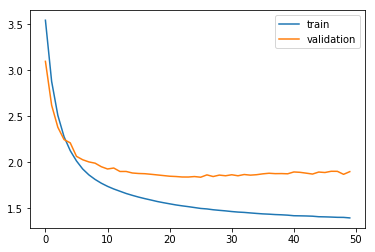

In [14]:
iterations=0
def detach(states):
    return [state.detach() for state in states] 
while(epoch<50):  # again, normally you would NOT do 300 epochs, it is toy data
    #train set
    iterations=iterations+1
    loss = 0
    hidden = model.init_hidden()
    for i in range(len(training_data)//batch_size):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        letter = training_data[i*batch_size:(i+1)*batch_size]
        targets = training_targets[i*batch_size:(i+1)*batch_size]
        #letter = training_data[i][0]
        model.zero_grad()
        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        #model.hidden = model.init_hidden()
        #model.hidden=self_hidden
            #model.hidden = self_hidden
            #model.hidden = (autograd.Variable(hiddenstate[0].cuda()),autograd.Variable(hiddenstate[1].cuda()))
        #model.hidden=self_hidden
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        letter_in = prepare_sequence(letter, word_to_ix)
        targets = prepare_sequence(targets, word_to_ix)
        #targets = one_hot(targets,EMBEDDING_DIM)
        # Step 3. Run our forward pass.
        if use_gpu:
            letter_in = letter_in.cuda()
            targets = targets.cuda()
        tag_scores,hidden = model(letter_in,hidden)
        hidden = detach(hidden)
        tag_scores = tag_scores.view(sentencelen*batch_size,-1)
        targets = targets.view(sentencelen*batch_size)
        #print(targets.size())
        #hiddenstate=(torch.FloatTensor(self_hidden[0].data.cpu().numpy()),torch.FloatTensor(self_hidden[1].data.cpu().numpy()))
        #print(mid)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        train_loss = loss_function(tag_scores, targets)
        #train_loss.backward()
        train_loss.backward(retain_graph=True)
        optimizer.step()
        loss = loss+train_loss.data[0]
    loss=loss/(len(training_data)//batch_size)
    print(loss)
    error_train.append(loss)
    
    #test set
    loss=0
    hidden = model.init_hidden()
    for i in range(len(test_data)//batch_size):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
           # We need to clear them out before each instance
        letter = test_data[i*batch_size:(i+1)*batch_size]
        targets = test_targets[i*batch_size:(i+1)*batch_size]
        letter_in = prepare_sequence(letter, word_to_ix)
        targets = prepare_sequence(targets, word_to_ix)
        
        if use_gpu:
            letter_in = letter_in.cuda()
            targets = targets.cuda()
        #print(letter_in)
     
        tag_scores,hidden = model(letter_in,hidden)
        tag_scores = tag_scores.view(sentencelen*batch_size,-1)
        targets = targets.view(sentencelen*batch_size)
        test_loss = loss_function(tag_scores, targets)
        loss = loss+test_loss.data[0]
    loss=loss/(len(test_data)//batch_size)
    error_valid.append(loss)
    epoch = epoch+1
    print(loss)
    #if(loss>loss_f):
     #   k = k+1
    #else:
     #   k = 0
    #if(k>2):
     #   break
    #loss_f = loss 

import matplotlib.pyplot as plt
plt.figure
l1,=plt.plot(range(epoch),error_train,label='train')
l2,=plt.plot(range(epoch),error_valid,label='validation')
plt.legend(handles = [l1, l2, ], labels = ['train', 'validation'], loc = 'best')
plt.savefig("error.png",dpi=120)
plt.show()
torch.save(model.state_dict(),'mytraining.pth')